# Chapter 6

In [1]:
import matplotlib.pyplot as plt
import arviz as az
import pymc3 as pm
import scipy.stats as stats
import numpy as np
import theano.tensor as tt
import pandas as pd

## Exercise 1

In [2]:
vals = stats.norm.rvs(loc=[10,20,30], scale=1, size=(100,3)).flatten()
vals[:5]

array([10.15402978, 20.45516347, 29.6614377 , 11.41017896, 22.07526163])

Let's plot a kde plot to see what things look like

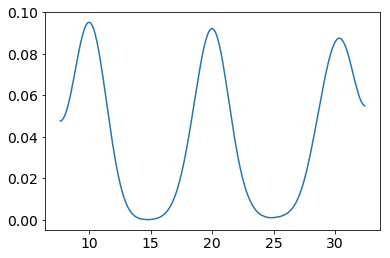

In [3]:
az.plot_kde(vals)

### Fit 2, 3, and 4 component mixture models

In [4]:
clusters = [2,3,4]
traces = {}
for cluster in clusters:
    with pm.Model() as two_components:
        p = pm.Dirichlet("p", a=np.ones(cluster)*10)

        # Each mean of the mixture data has its own estimate of a mean with a fixed SD in this case
        means = pm.Normal("means", mu=np.linspace(vals.min(), vals.max(), cluster), 
                          sd=10., shape=cluster, transform=pm.distributions.transforms.ordered)
        
        # Estimate of the standard deviation of what?
        sd = pm.HalfCauchy("sd", 1)
        y = pm.NormalMixture("y", w=p, mu=means, sd=sd, observed=vals)
        
        trace = pm.sample(random_seed=123)
        traces[f"Cluster Size {cluster}"] = az.from_pymc3(trace=trace)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sd, means, p]
Sampling 4 chains: 100%|██████████| 4000/4000 [00:02<00:00, 1633.87draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sd, means, p]
Sampling 4 chains: 100%|██████████| 4000/4000 [00:03<00:00, 1066.75draws/s]
The acceptance probability does not match the target. It is 0.8977488503700709, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8805490354521531, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sd, means, p]
Sampling 4 chains: 100%|██████████| 4000/4000 [00:06<00:00, 580.67draws/s]
There were 21 divergences after tuning. Increase 

# Exercise 2

In [5]:
comparison = az.compare(traces)
comparison

/home/canyon/repos/arviz/arviz/stats/stats.py:1118: UserWarning: For one or more samples the posterior variance of the log predictive
        densities exceeds 0.4. This could be indication of WAIC starting to fail see
        http://arxiv.org/abs/1507.04544 for details
        
  """


,rank,waic,p_waic,d_waic,weight,se,dse,warning,waic_scale
Cluster Size 3,0,1545.05,5.84599,0,0.687055,25.8115,0,True,deviance
Cluster Size 4,1,1546.76,7.61696,1.71189,0.312945,4.36737,1.19632,True,deviance
Cluster Size 2,2,2070.55,2.97963,525.507,2.18336e-96,25.7846,26.4456,False,deviance


In [6]:
az.loo(traces["Cluster Size 2"])

Computed from 2000 by 300 log-likelihood matrix

       Estimate       SE
IC_loo  2070.55     4.33
p_loo      2.98        -

In [7]:
az.loo(traces["Cluster Size 3"])

Computed from 2000 by 300 log-likelihood matrix

       Estimate       SE
IC_loo  1545.04    26.16
p_loo      5.84        -

In [8]:
az.loo(traces["Cluster Size 4"])

Computed from 2000 by 300 log-likelihood matrix

       Estimate       SE
IC_loo  1546.75    26.17
p_loo      7.61        -

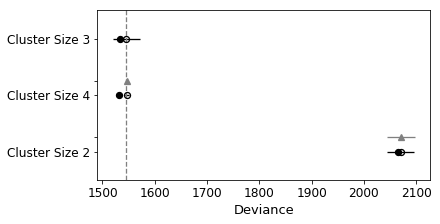

In [9]:
az.plot_compare(comparison)

In [ ]:
az.plot_trace(traces["Cluster Size 3"])

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f67c1a5add8>,
      dtype=object)

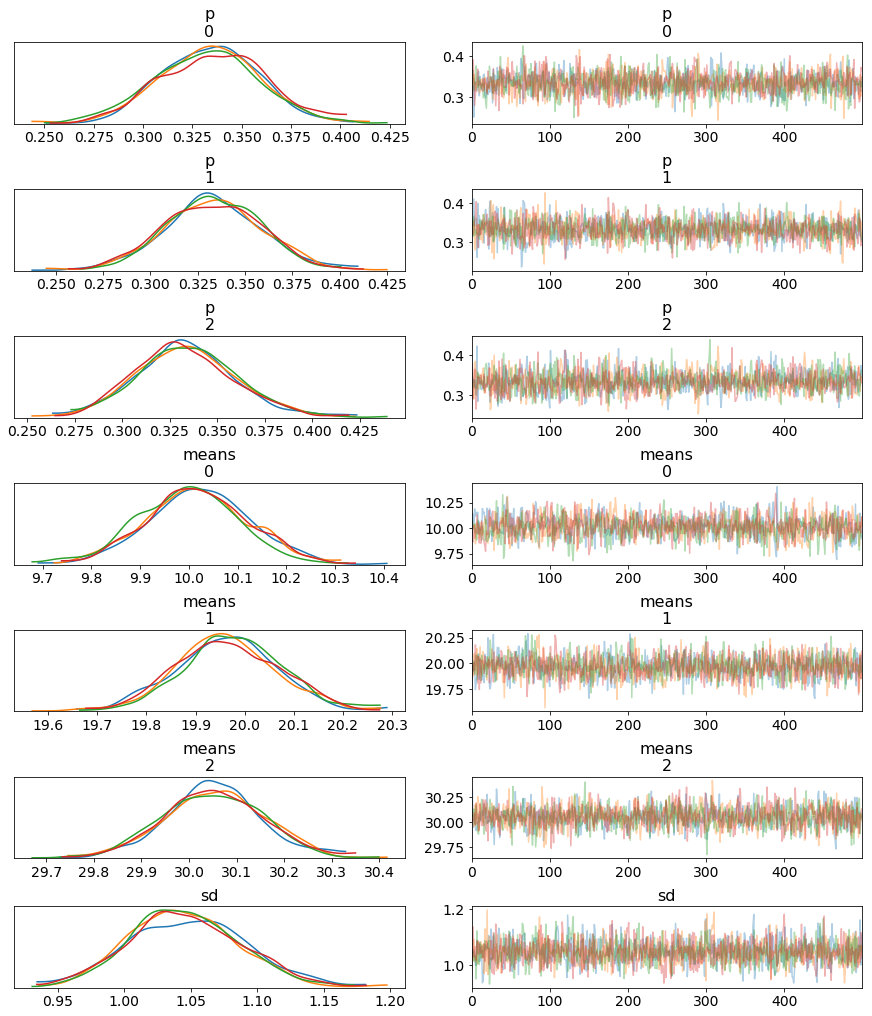

In [10]:
az.plot_trace(traces["Cluster Size 3"])

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f67c1053da0>,
      dtype=object)

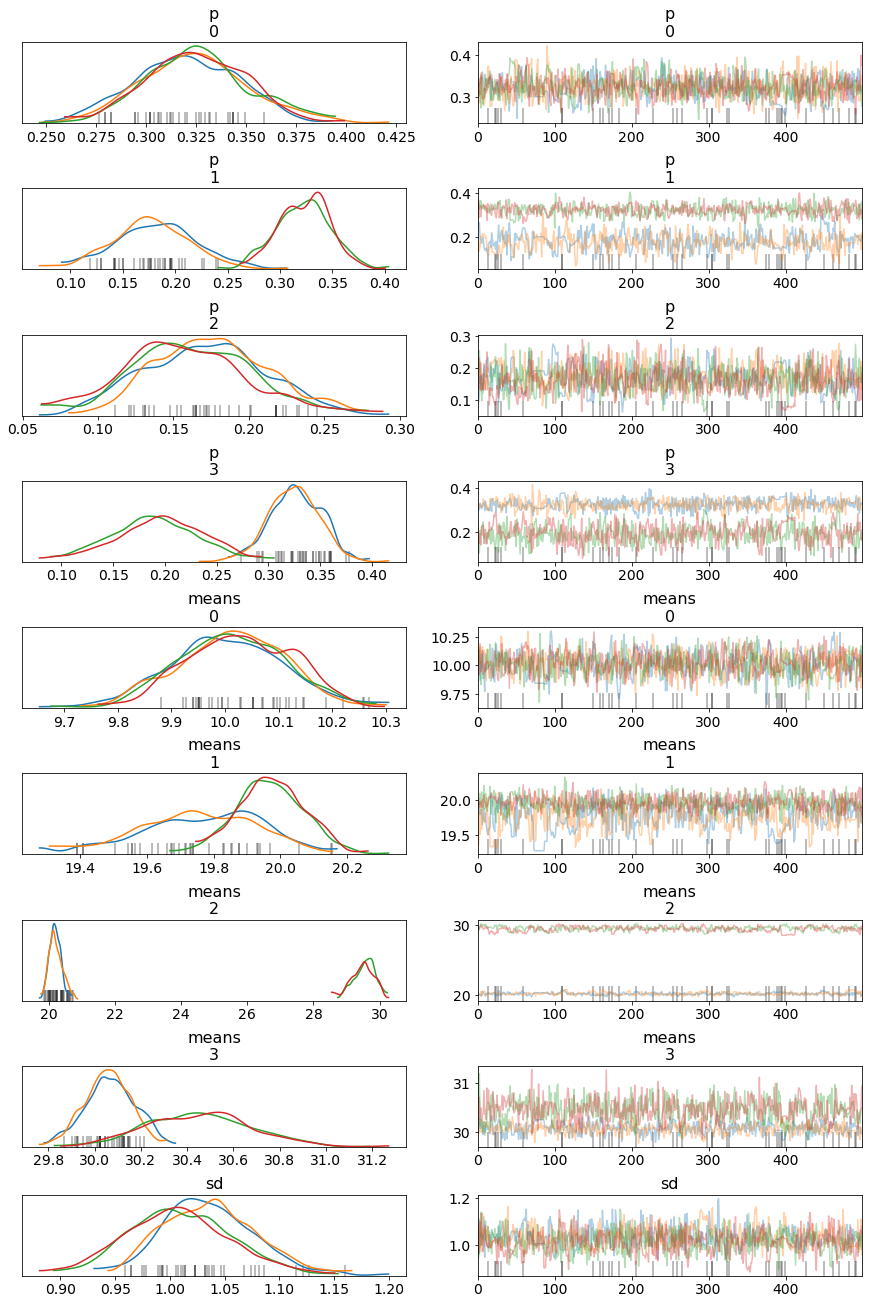

In [11]:
az.plot_trace(traces["Cluster Size 4"])

## Exercise 4

In [12]:
K=20

def stick_breaking(α, K):
    β = pm.Beta('β', 1., α, shape=K)
    w = β * pm.math.concatenate([[1.], tt.extra_ops.cumprod(1. - β)[:-1]])
    return w

In [13]:
print(K)
with pm.Model() as model:
    α = pm.Gamma('α', 1, 1.)
    w = pm.Deterministic('w', stick_breaking(α, K))
    means = pm.Normal('means',
                      mu=np.linspace(vals.min(), vals.max(), K),
                      sd=1, shape=K)
    sd = pm.HalfNormal('sd', sd=1, shape=K)
    
    obs = pm.NormalMixture('obs', w, means, sd=sd, observed=vals)
    trace = pm.sample(10000, tune=5000, nuts_kwargs={'target_accept':0.85})

20


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sd, means, β, α]
Sampling 4 chains: 100%|██████████| 60000/60000 [03:06<00:00, 321.88draws/s]
The chain contains only diverging samples. The model is probably misspecified.
There were 9325 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7777102173464806, but should be close to 0.85. Try to increase the number of tuning steps.
There were 9971 divergences after tuning. Increase `target_accept` or reparameterize.
There were 9997 divergences after tuning. Increase `target_accept` or reparameterize.
The gelman-rubin statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


## Exercise 5

In [14]:
iris = pd.read_csv('../code/data/iris.csv')
sepal_length = iris["sepal_length"].values

In [15]:
clusters = 3
with pm.Model() as model_mg:
    p = pm.Dirichlet('p', a=np.ones(clusters))
    means = pm.Normal('means', mu=sepal_length.mean(), sd=10, shape=clusters)
    
    sd = pm.HalfNormal('sd', sd=10)
    y = pm.NormalMixture('y', w=p, mu=means, sd=sd, observed=sepal_length)
    sepal_trace = pm.sample(5000, tune=2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sd, means, p]
Sampling 4 chains: 100%|██████████| 28000/28000 [00:56<00:00, 492.38draws/s]
There were 207 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.3947439237807297, but should be close to 0.8. Try to increase the number of tuning steps.
There were 98 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.3394767262935066, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.905734901653858, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9351776658710003, but should be close to 0.8. Try to increase the number of tuning steps.
The est

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f67aacf49b0>,
      dtype=object)

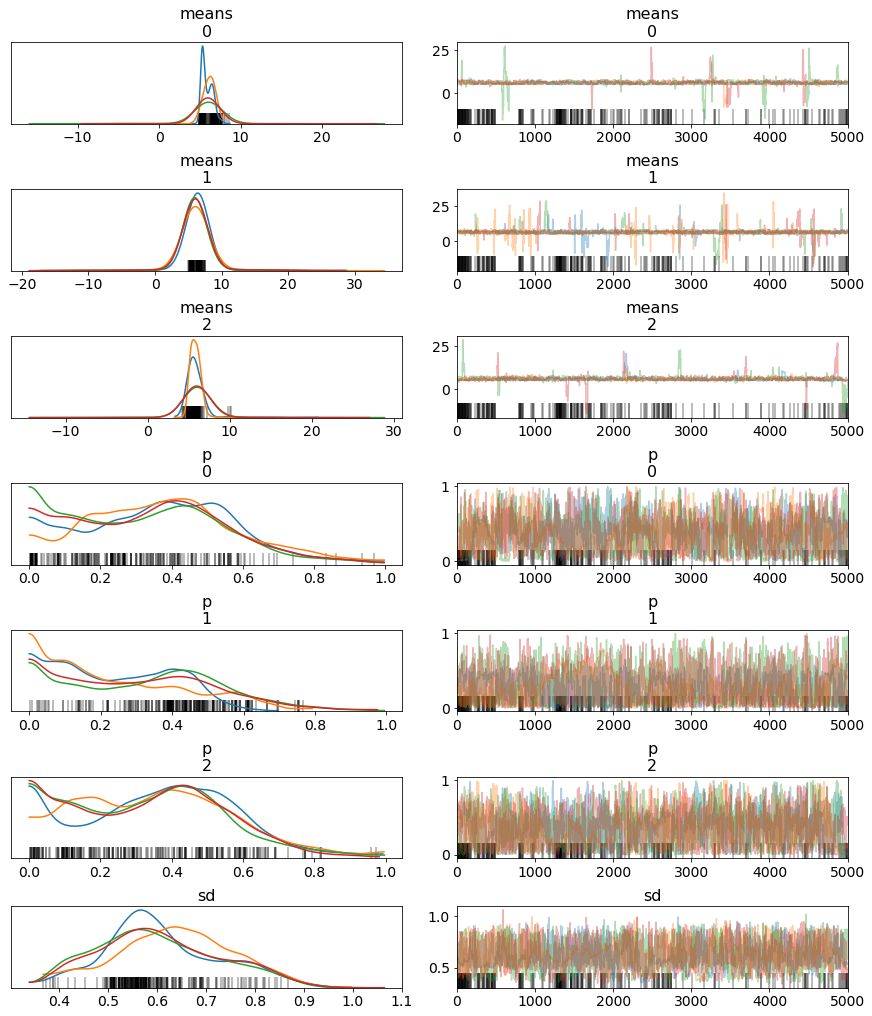

In [16]:
az.plot_trace(sepal_trace)

## Exercise 6

In [17]:
iris = pd.read_csv('../code/data/iris.csv')
sepal_length = iris["sepal_length"].values
sepal_width = iris["sepal_width"].values

In [18]:
clusters = 3
with pm.Model() as model_mg:
    # Sepal Width
    p_sepal_width = pm.Dirichlet('p_sepal_width', a=np.ones(clusters))
    means_sepal_width = pm.Normal('means_sepal_width', mu=sepal_width.mean(), sd=10, shape=clusters)
    sd_sepal_width = pm.HalfNormal('sd_sepal_width', sd=1)
    sepal_width_y = pm.NormalMixture('sepal_width_y', w=p_sepal_width, mu=means_sepal_width, sd=sd_sepal_width, observed=sepal_width)
    
    # Sepal length
    p_sepal_length = pm.Dirichlet('p_sepal_length', a=np.ones(clusters))
    means_sepal_length = pm.Normal('means_sepal_length', mu=sepal_length.mean(), sd=10, shape=clusters)
    sd_sepal_length = pm.HalfNormal('sd_sepal_length', sd=1)
    sepal_length_y = pm.NormalMixture('sepal_length_y', w=p_sepal_length, mu=means_sepal_length, sd=sd_sepal_length, observed=sepal_length)
    
    
    sepal_length_width_trace = pm.sample(5000, tune=2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sd_sepal_length, means_sepal_length, p_sepal_length, sd_sepal_width, means_sepal_width, p_sepal_width]
Sampling 4 chains: 100%|██████████| 28000/28000 [03:59<00:00, 23.74draws/s]
There were 77 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.460858910665501, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9862925290172161, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9846977024549958, but should be close to 0.8. Try to increase the number of tuning steps.
The gelman-rubin statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective sample

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f67aa7abba8>,
      dtype=object)

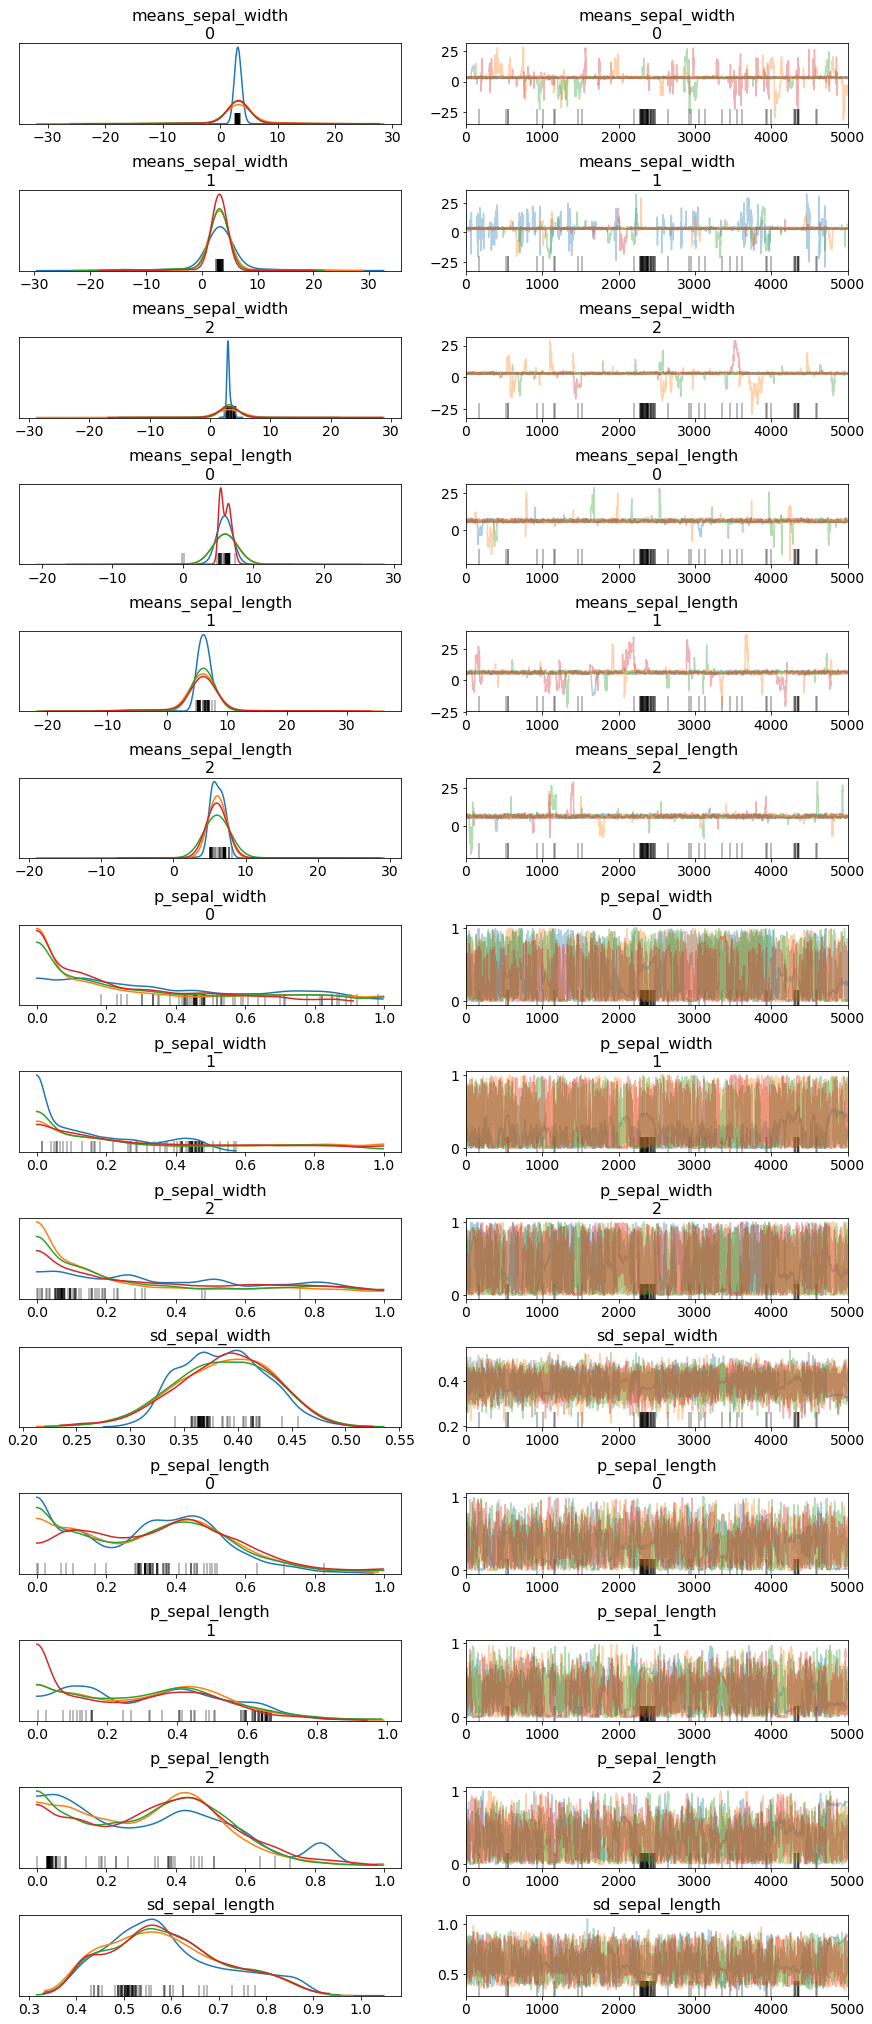

In [19]:
az.plot_trace(sepal_length_width_trace)